In [29]:
import json
import re
from glob import glob
import seaborn as sns
from constants import MAX_KEYWORD_STR
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
json_paths = glob('data/roc_auc*.json')
json_paths

['data/roc_auc_ws1_0.json',
 'data/roc_auc_ws2_0.json',
 'data/roc_auc_ws4_0.json',
 'data/roc_auc_ws6_0.json']

In [7]:
window_size_rgx = r'data/roc_auc.*?_ws(\d+_?\d*)\.json'
get_window_size_str = lambda p: re.search(window_size_rgx, p).group(1)
window_str_to_float = lambda ws_str: float(ws_str.replace('_', '.'))

window_size_to_json_path = {
    window_str_to_float(get_window_size_str(p)): p for p in json_paths
}

window_size_to_json_path


{1.0: 'data/roc_auc_ws1_0.json',
 2.0: 'data/roc_auc_ws2_0.json',
 4.0: 'data/roc_auc_ws4_0.json',
 6.0: 'data/roc_auc_ws6_0.json'}

In [13]:
window_size_to_roc_auc = {}
for window_size, json_path in window_size_to_json_path.items():
    with open(json_path, 'r') as f:
        data = json.load(f)
    max_roc_auc = [
        roc_auc_data for roc_auc_data in data
        if roc_auc_data['keyphrase'] == MAX_KEYWORD_STR
    ]

    window_size_to_roc_auc[window_size] = max_roc_auc[0]

window_size_to_roc_auc[1.0].keys()

dict_keys(['keyphrase', 'tira>tira', 'tira>english', 'tira>tira/english'])

In [23]:
roc_data = []
auc_data = []
roc_auc_types = ['tira>tira', 'tira>tira/english', 'tira>english']

for window_size, roc_auc_data in window_size_to_roc_auc.items():
    for roc_auc_type in roc_auc_types:
        auc_data.append({
            'window_size': window_size,
            'type': roc_auc_type,
            'auc': roc_auc_data[roc_auc_type]['auc'],
        })
        for fpr, tpr in zip(
            roc_auc_data[roc_auc_type]['fpr'],
            roc_auc_data[roc_auc_type]['tpr'],
            # roc_auc_data[roc_auc_type]['threshold'],
        ):
            roc_data.append({
                'window_size': window_size,
                'type': roc_auc_type,
                'fpr': fpr,
                'tpr': tpr,
                # 'threshold': threshold,
            })

roc_df = pd.DataFrame(roc_data)
auc_df = pd.DataFrame(auc_data)
roc_df.shape, auc_df.shape

((24618, 4), (12, 3))

In [25]:
auc_df.head()

,window_size,type,auc
0,1.0,tira>tira,0.709618
1,1.0,tira>tira/english,0.967721
2,1.0,tira>english,0.999936
3,2.0,tira>tira,0.657672
4,2.0,tira>tira/english,0.911941


In [26]:
roc_df.head()

,window_size,type,fpr,tpr
0,1.0,tira>tira,0.000000,0.000000
1,1.0,tira>tira,0.000000,0.000375
2,1.0,tira>tira,0.000000,0.000750
3,1.0,tira>tira,0.000884,0.000750
4,1.0,tira>tira,0.000884,0.005625


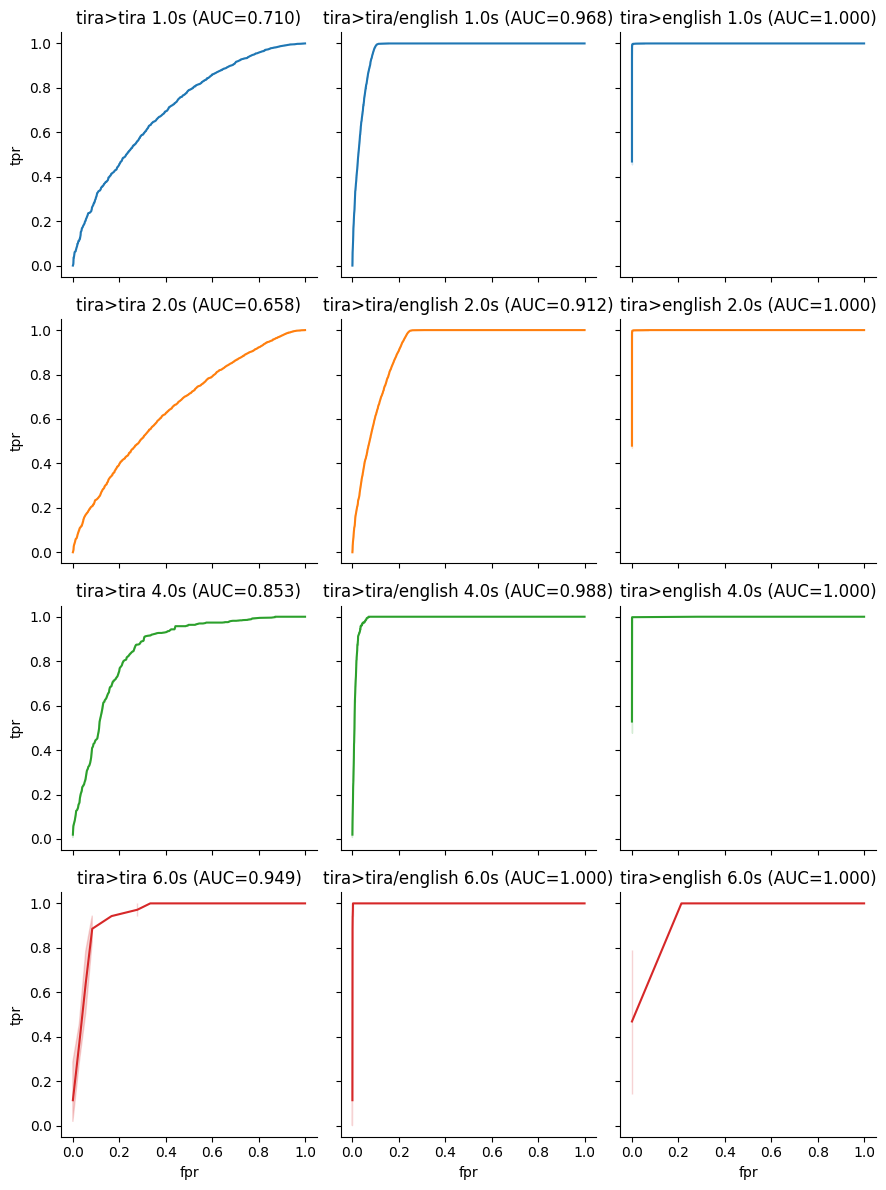

In [32]:
g=sns.FacetGrid(
    roc_df, col='type', row='window_size', hue='window_size'
)
# build lookup of auc by (window_size, type)
auc_map = auc_df.set_index(['window_size', 'type'])['auc'].to_dict()

# set titles per facet: rows are window_size, cols are type
for i, row_val in enumerate(g.row_names):
    for j, col_val in enumerate(g.col_names):
        try:
            ws = float(row_val)
        except Exception:
            ws = row_val
        auc = auc_map.get((ws, col_val))
        title = f"{col_val} {row_val}s"
        if auc is not None:
            title += f" (AUC={auc:.3f})"
        g.axes[i, j].set_title(title)
g.map(sns.lineplot, 'fpr', 'tpr')
plt.show()

Let's get some duration and frequency numbers from the datasets to contextualize.

In [42]:
from dataloading import load_tira_drz
from constants import PREDICTED_WORDS_CSV


drz_ds = load_tira_drz()['train']

asr_df = pd.read_csv(PREDICTED_WORDS_CSV)
asr_df = asr_df[~asr_df['unique']]
drz_df = drz_ds.remove_columns(['audio']).to_pandas()

eng_mask = drz_df['transcription'] == 'ENG'
drz_df = drz_df[eng_mask]

asr_df['duration'] = asr_df['end']-asr_df['start']
drz_df['duration'] = drz_df['end']-drz_df['start']

ms_per_sec = 1_000
asr_df['duration_sec'] = asr_df['duration'] / ms_per_sec
drz_df['duration_sec'] = drz_df['duration'] / ms_per_sec

asr_df.shape, drz_df.shape

((13614, 13), (4546, 13))

In [44]:
duration_bins = [
    (0, 2), (1, 3), (3, 5), (5, 7)
]

def get_stats_for_duration_bin(duration_bin):
    min_dur, max_dur = duration_bin
    asr_bin_df = asr_df[asr_df['duration_sec'].between(min_dur, max_dur)]
    drz_bin_df = drz_df[drz_df['duration_sec'].between(min_dur, max_dur)]

    asr_num_utterances = asr_bin_df.shape[0]
    drz_num_utterances = drz_bin_df.shape[0]

    asr_num_unique_keyphrases = asr_bin_df['transcription'].nunique()
    asr_avg_tokens_per_utt = asr_num_utterances/asr_num_unique_keyphrases

    sec_per_hr = 3_600
    asr_total_duration = asr_bin_df['duration_sec'].sum() / sec_per_hr
    drz_total_duration = drz_bin_df['duration_sec'].sum() / sec_per_hr
    return {
        'duration_bin': f"{min_dur}-{max_dur}s",
        'asr_num_utterances': asr_num_utterances,
        'drz_num_utterances': drz_num_utterances,
        'asr_num_unique_keyphrases': asr_num_unique_keyphrases,
        'asr_avg_tokens_per_utt': asr_avg_tokens_per_utt,
        'asr_total_duration_hr': asr_total_duration,
        'drz_total_duration_hr': drz_total_duration,
    }

duration_bins_stats = [
    get_stats_for_duration_bin(db) for db in duration_bins
]
duration_bin_df = pd.DataFrame(duration_bins_stats)
duration_bin_df

,duration_bin,asr_num_utterances,drz_num_utterances,asr_num_unique_keyphrases,asr_avg_tokens_per_utt,asr_total_duration_hr,drz_total_duration_hr
0,0-2s,7596,2883,3114,2.439306,3.407122,0.722171
1,1-3s,12382,1748,4304,2.876859,6.614637,0.879979
2,3-5s,990,568,656,1.509146,0.980958,0.608448
3,5-7s,71,268,52,1.365385,0.109027,0.439681


Let's get mean and variance duration for each keyphrase

In [54]:
keyphrase_durations = asr_df.groupby('transcription')['duration_sec']
mean_durations = keyphrase_durations.mean()
var_durations = keyphrase_durations.var()
keyphrase_duration_df = pd.DataFrame({
    'mean_duration_sec': mean_durations,
    'var_duration_sec': var_durations,
}).sort_values(by='var_duration_sec', ascending=False)

keyphrase_duration_df.head()

,mean_duration_sec,var_duration_sec
transcription,,
kìjɔ́ ŋɔ́mɔ̀ nɛ̀ ŋábr̀t̪ɛ̀ ŋɔ̀ɽíŋgɔ́ unɛɾɛ,4.020000,7.956100
ìɾí ŋgájíð́ìnɔ̀ kɜ́nà ìt̪ìlɔ́ kə́r mɔ̀lɔ̀,4.033500,7.117765
án ìdɜ̀ɽì kèró íŋgárnà ɲiroba,3.575000,5.412050
kìjɔ́ ŋɔ́mɔ̀ nɛ̀ ŋáðə̀ŋnɛ̀ ùɽùwɔ̀ ánó unɛɾɛ,3.863333,4.583433
kìjɔ́ ŋɔ́mɔ̀ nɛ̀ ŋə̀búrŋɛ̀ ánó ðìɲú ðə́lɔ̀ɽíŋí unɛɾɛ,3.745800,4.113498
